In [1]:
%%time
import numpy as np
import catboost as cb
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")
pd.options.display.max_columns = None
dtrain=pd.read_csv("C:/Users/Landy/Desktop/Angela/esun_credit/train.csv")
# dtrain=dtrain.sort_values(by=['txkey'],ascending=True)
# dtest=pd.read_csv("C:/Users/Landy/Desktop/Angela/esun_credit/test.csv")
dtrain

Wall time: 6.12 s


,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
0,6881,113261,38038,513.80,5,0,N,0,N,N,0,5,N,0,33,172652.0,457,59333,N,0,102,0,516056
1,0,134508,45725,465.62,5,0,N,2,N,N,0,0,N,0,9,105114.0,451,0,N,5817,102,0,4376
2,6881,15408,188328,513.80,5,0,N,0,N,N,0,5,N,0,6,152458.0,457,59333,N,0,102,0,483434
3,6716,157159,29967,1016.11,5,62,N,5,N,N,0,5,N,0,5,172946.0,247,50436,N,3281,102,0,1407164
4,5975,105985,81305,713.66,5,62,N,4,N,N,0,5,N,0,6,182129.0,263,93775,N,5817,102,0,1051004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521782,6322,91008,15189,578.38,5,75,Y,8,NaN,NaN,0,6,N,0,4,191642.0,209,38222,N,5817,102,0,1478280
1521783,3226,145107,116252,435.32,5,75,Y,8,NaN,NaN,0,6,N,0,13,102338.0,192,90135,N,1458,102,0,661087
1521784,6769,162168,93598,1.38,5,75,Y,8,NaN,NaN,0,6,N,0,29,234618.0,373,79246,N,5817,102,0,167073
1521785,6032,45406,197460,1.38,5,75,Y,2,NaN,NaN,0,6,N,0,24,215218.0,373,79246,N,5817,102,0,338215


In [2]:
# fraud percent
print('No Frauds', round(dtrain['fraud_ind'].value_counts()[0]/len(dtrain) * 100,2), '% of the dataset')
print('Frauds', round(dtrain['fraud_ind'].value_counts()[1]/len(dtrain) * 100,2), '% of the dataset')

No Frauds 98.66 % of the dataset
Frauds 1.34 % of the dataset


In [3]:
# flbmk跟flg_3dsmk會同步null
dtrain.isna().sum()

acqic            0
bacno            0
cano             0
conam            0
contp            0
csmcu            0
ecfg             0
etymd            0
flbmk        12581
flg_3dsmk    12581
fraud_ind        0
hcefg            0
insfg            0
iterm            0
locdt            0
loctm            0
mcc              0
mchno            0
ovrlt            0
scity            0
stocn            0
stscd            0
txkey            0
dtype: int64

In [4]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

columns_names=[c for c in dtrain.columns if c not in ['fraud_ind']]

uni=[]
for col in columns_names:
    uni.append(dtrain[col].unique())

from random import sample
ex_value=[]
uni_len=[]

# uni_len & ex_value
for i in range(len(uni)):
    uni_len.append(len(uni[i]))
    if len(uni[i])<10:
        ex_value.append(uni[i])
    else:
        ex_value.append(sample(list(uni[i]), 5))

columns_chinese=['收單行代碼(跟商店合作的銀行)','歸戶帳號(持卡人帳戶)','交易卡號(1 bacno對多cano)','交易金額-台幣(經轉換)','交易類別','消費地幣別','網路交易註記','交易型態(ex.刷磁條機)','Fallback註記(銀行懷疑的註記)','3DS交易註記(收簡訊)','支付型態(ex.linepay)','分期交易註記','分期期數(0~8)','授權日期(1到90天)','授權時間(時分秒)','MCC_CODE(商戶類別碼)','特約商店(買的地方)','超額註記碼(卡刷爆了)','消費城市','消費地國別','狀態碼(ex.停卡掛失逾期)','交易序號(流水號)']

dtrain_details = pd.DataFrame({
    'columns_names':columns_names, 
    'columns_chinese':columns_chinese,
    'uni_len':uni_len,
    'ex_value':ex_value
    })

dtrain_details

,columns_names,columns_chinese,uni_len,ex_value
0,acqic,收單行代碼(跟商店合作的銀行),6051,"[322, 5017, 526, 3375, 6063]"
1,bacno,歸戶帳號(持卡人帳戶),95214,"[90285, 12397, 149893, 20889, 31361]"
2,cano,交易卡號(1 bacno對多cano),129413,"[121644, 79806, 65310, 50753, 11560]"
3,conam,交易金額-台幣(經轉換),72961,"[953.79, 1727.45, 796.79, 863.44, 360.14]"
4,contp,交易類別,7,"[5, 3, 6, 2, 4, 0, 1]"
5,csmcu,消費地幣別,72,"[36, 15, 12, 42, 54]"
6,ecfg,網路交易註記,2,"[N, Y]"
7,etymd,交易型態(ex.刷磁條機),11,"[3, 8, 10, 1, 0]"
8,flbmk,Fallback註記(銀行懷疑的註記),3,"[N, Y, nan]"
9,flg_3dsmk,3DS交易註記(收簡訊),3,"[N, Y, nan]"


In [5]:
def get_month(df):
    df['Month'] = 0
    df.loc[df['locdt'] <= 120, 'Month'] = 4
    df.loc[df['locdt'] <= 90, 'Month']  = 3
    df.loc[df['locdt'] <= 60, 'Month']  = 2
    df.loc[df['locdt'] <= 30, 'Month'] = 1
    return df

dtrain=get_month(dtrain)
# dtest=get_month(dtest)

In [6]:
# 00:00:00=時分秒，個位數分不補0 
dtrain['loctm'] = dtrain['loctm'].astype(int).astype(str)

def get_prefix(loctm):
    loctm = str(int(loctm))
    if len(loctm) < 6:
        loctm = (6 - len(loctm)) * '0' + loctm
    return loctm

dtrain['loctm_hour'] = dtrain['loctm'].apply(lambda x :get_prefix(x)[0:2])
# dtest['loctm_hour'] = dtrain['loctm'].apply(lambda x :get_prefix(x)[0:2])

In [7]:
fraud_1df = dtrain.loc[dtrain['fraud_ind'] == 1]
fraud_1df

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,Month,loctm_hour
70,3288,88538,81033,1.38,5,62,Y,8,N,N,1,5,N,0,7,45457,337,20984,N,621,93,2,651056,1,04
349,6881,157859,82925,513.80,5,0,N,0,N,N,1,5,N,0,23,154137,457,59360,N,0,102,0,503429,1,15
1133,6769,34663,73355,677.88,5,62,Y,8,N,N,1,5,N,0,54,172810,373,79663,N,5817,102,0,259268,2,17
1208,6856,74183,18151,229.61,5,62,Y,8,N,N,1,5,N,0,32,112902,288,69240,N,0,104,0,1423892,2,11
1254,6881,125183,48320,513.80,5,0,N,0,N,N,1,5,N,0,67,45823,457,59360,N,0,102,0,554270,3,04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521552,6215,136379,138279,111.17,5,75,Y,2,NaN,NaN,1,6,N,0,16,172346,380,54238,N,6580,38,0,1849443,1,17
1521712,6215,136379,138279,111.17,5,75,Y,2,NaN,NaN,1,6,N,0,17,12250,380,54238,N,6580,38,0,1849997,1,01
1521718,6760,127255,129019,796.90,5,75,Y,2,NaN,NaN,1,6,N,0,5,182601,296,66694,N,3323,27,0,1837945,1,18
1521751,6215,96677,148700,1016.34,5,75,Y,2,NaN,NaN,1,6,N,0,28,203808,380,54238,N,6580,38,0,1862452,1,20


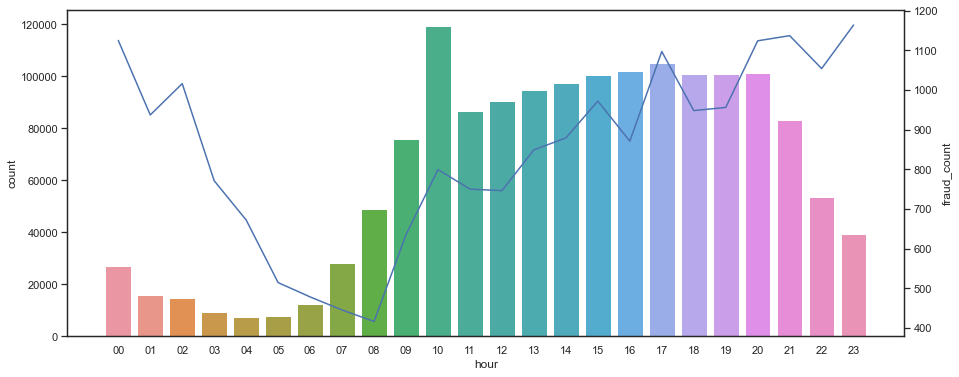

Wall time: 1.9 s


In [8]:
%%time
fig, ax = plt.subplots(figsize=(15,6))
# 各時段的交易量 & 盜刷趨勢，盜刷很多位於21~02
dtrain1=dtrain.sort_values(by=['locdt','loctm_hour'],ascending=True)
transcount=dtrain1.groupby('loctm_hour')['txkey'].count()
transcount=pd.DataFrame({'hour':transcount.index, 'count':transcount.values})

fraud_1df1=fraud_1df.sort_values(by=['locdt','loctm_hour'],ascending=True)
fraudcount=fraud_1df1.groupby('loctm_hour')['txkey'].count()
# fraudcount=pd.DataFrame({'hour':fraudcount.index, 'fraud_count':fraudcount.values})
transcount['fraud_count'] = fraudcount.values

sns.barplot(x='hour',y='count',ax=ax,data=transcount)
ax2 = ax.twinx()
sns.lineplot(x='hour',y='fraud_count',ax=ax2,data=transcount)
plt.show()

In [9]:
ecfg_train = dtrain.loc[dtrain['ecfg'] == 'Y']
# ecfg_test = dtest.loc[dtest['ecfg'] == 'Y']

a=dtrain.groupby(['bacno','cano'])['txkey']
print(a.agg(np.size))

b=ecfg_train.groupby(['bacno','cano'])['txkey']
print(b.agg(np.size))

bacno   cano  
1       117264     11
2       96923     117
        101554     11
        101555     21
        101556      9
                 ... 
163878  35648       3
163879  87074       5
163882  210889     15
163883  131212     27
163884  211804     26
Name: txkey, Length: 129413, dtype: int64
bacno   cano  
1       117264     4
2       101554     3
        101555     3
3       190586     5
7       78063     11
                  ..
163864  172124     8
163874  162583     1
163876  27009      2
163882  210889     5
163884  211804     6
Name: txkey, Length: 58393, dtype: int64


In [10]:
# groupby 持卡人帳戶(bacno)，count by txkey，transform保持原來資料數目
dtrain['Count_txkey_gb_same_person'] =  dtrain.groupby(['bacno'])['txkey'].transform('count')
# groupby 持卡人帳戶(bacno)跟卡號(cano)，同人同卡號，count by txkey，transform保持原來資料數目
dtrain['Count_txkey_gb_same_card'] =  dtrain.groupby(['bacno', 'cano'])['txkey'].transform('count')
# groupby 持卡人帳戶(bacno)跟卡號(cano)，同人同卡號同天，count by txkey，transform保持原來資料數目
dtrain['Count_txkey_gb_same_card_same_day'] =  dtrain.groupby(['bacno','cano' ,'locdt'])['txkey'].transform('count')
# groupby 持卡人帳戶(bacno)跟卡號(cano)，同人同卡號同小時，count by txkey，transform保持原來資料數目
dtrain['Count_txkey_gb_same_card_same_hour'] =  dtrain.groupby(['bacno','cano' ,'loctm_hour'])['txkey'].transform('count')
# groupby 持卡人帳戶(bacno)跟卡號(cano)，同人同卡號同天同種網路or實體付款，count by txkey，transform保持原來資料數目
dtrain['Count_txkey_gb_same_card_same_day_ecfg'] =  dtrain.groupby(['bacno','cano' ,'locdt','ecfg'])['txkey'].transform('count')
# 網路消費比率
dtrain['Percent_of_ecfg'] = ecfg_train.groupby(['bacno','cano'])['txkey'].transform('count')/dtrain.groupby(['bacno','cano'])['txkey'].transform('count')
dtrain['Percent_of_ecfg'].fillna(value=0,inplace=True)

dtrain

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,Month,loctm_hour,Count_txkey_gb_same_person,Count_txkey_gb_same_card,Count_txkey_gb_same_card_same_day,Count_txkey_gb_same_card_same_hour,Count_txkey_gb_same_card_same_day_ecfg,Percent_of_ecfg
0,6881,113261,38038,513.80,5,0,N,0,N,N,0,5,N,0,33,172652,457,59333,N,0,102,0,516056,2,17,80,80,4,12,4,0.000000
1,0,134508,45725,465.62,5,0,N,2,N,N,0,0,N,0,9,105114,451,0,N,5817,102,0,4376,1,10,23,23,1,7,1,0.000000
2,6881,15408,188328,513.80,5,0,N,0,N,N,0,5,N,0,6,152458,457,59333,N,0,102,0,483434,1,15,18,18,1,4,1,0.000000
3,6716,157159,29967,1016.11,5,62,N,5,N,N,0,5,N,0,5,172946,247,50436,N,3281,102,0,1407164,1,17,74,57,3,8,2,0.000000
4,5975,105985,81305,713.66,5,62,N,4,N,N,0,5,N,0,6,182129,263,93775,N,5817,102,0,1051004,1,18,78,63,1,7,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521782,6322,91008,15189,578.38,5,75,Y,8,NaN,NaN,0,6,N,0,4,191642,209,38222,N,5817,102,0,1478280,1,19,11,11,2,2,1,0.181818
1521783,3226,145107,116252,435.32,5,75,Y,8,NaN,NaN,0,6,N,0,13,102338,192,90135,N,1458,102,0,661087,1,10,59,56,5,15,4,0.589286
1521784,6769,162168,93598,1.38,5,75,Y,8,NaN,NaN,0,6,N,0,29,234618,373,79246,N,5817,102,0,167073,1,23,14,14,3,5,3,0.857143
1521785,6032,45406,197460,1.38,5,75,Y,2,NaN,NaN,0,6,N,0,24,215218,373,79246,N,5817,102,0,338215,1,21,27,27,3,6,3,0.370370


In [11]:
# Frauds 1.34 %，銀行抓出2%的盜刷，銀行懷疑有一點效
num=dtrain[(dtrain['flbmk'] == str('Y')) & (dtrain['fraud_ind']==1)].count()['txkey'] / dtrain[ dtrain['flbmk'] == str('Y')].count()['txkey']
print("flbmk=Y時銀行抓出"+"%0.2f" % num)
num1=dtrain[(dtrain['flbmk'] == str('N')) & (dtrain['fraud_ind']==1)].count()['txkey'] / dtrain[ dtrain['flbmk'] == str('N')].count()['txkey']
print("flbmk=N時銀行抓出"+"%0.2f" % num1)
num2=dtrain[(dtrain['flbmk'].isna()) & (dtrain['fraud_ind']==1)].count()['txkey'] / dtrain[ dtrain['flbmk'].isna()].count()['txkey']
print("flbmk=NaN時銀行抓出"+"%0.2f" % num2)

flbmk=Y時銀行抓出0.02
flbmk=N時銀行抓出0.01
flbmk=NaN時銀行抓出0.02


In [12]:
# Frauds 1.34 %，收簡訊較無效
num=dtrain[(dtrain['flg_3dsmk'] == str('Y')) & (dtrain['fraud_ind']==1)].count()['txkey'] / dtrain[ dtrain['flg_3dsmk'] == str('Y')].count()['txkey']
print("flg_3dsmk=Y時銀行抓出"+"%0.2f" % num)
num1=dtrain[(dtrain['flg_3dsmk'] == str('N')) & (dtrain['fraud_ind']==1)].count()['txkey'] / dtrain[ dtrain['flg_3dsmk'] == str('N')].count()['txkey']
print("flg_3dsmk=N時銀行抓出"+"%0.2f" % num1)
num2=dtrain[(dtrain['flg_3dsmk'].isna()) & (dtrain['fraud_ind']==1)].count()['txkey'] / dtrain[ dtrain['flg_3dsmk'].isna()].count()['txkey']
print("flg_3dsmk=NaN時銀行抓出"+"%0.2f" % num2)

flg_3dsmk=Y時銀行抓出0.00
flg_3dsmk=N時銀行抓出0.01
flg_3dsmk=NaN時銀行抓出0.02


In [13]:
# flbmk,flg_3dsmk用NA填值
dtrain['flbmk']=dtrain['flbmk'].fillna('NA')
dtrain['flg_3dsmk']=dtrain['flg_3dsmk'].fillna('NA')

In [14]:
# 網路刷卡人較少
print('實體交易', round(dtrain['ecfg'].value_counts()['N']/len(dtrain) * 100,2), '% of the dataset')
print('網路交易', round(dtrain['ecfg'].value_counts()['Y']/len(dtrain) * 100,2), '% of the dataset')

實體交易 74.55 % of the dataset
網路交易 25.45 % of the dataset


Wall time: 11.9 s


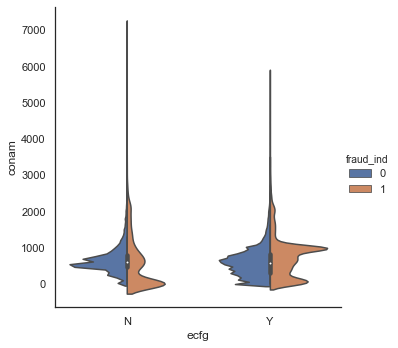

In [15]:
%%time
# 實體交易的金額上限比網路交易高
sns.catplot(x='ecfg',y='conam',hue='fraud_ind',kind="violin", split=True,data=dtrain)
# plt.savefig("C:/Users/Landy/Desktop/Angela/esun_credit/dtrain_conam.png")

In [16]:
# 網路盜刷,1000~1500
dtrain['ecfgY_conam1000_1500']=0
dtrain.loc[(1000<dtrain.conam) & (dtrain.conam<1500), 'ecfgY_conam1000_1500'] = 1
dtrain.loc[dtrain.ecfg==str("N"), 'ecfgY_conam1000_1500'] = 0
# 實體盜刷,0~400
dtrain['ecfgN_conam0_400']=0
dtrain.loc[dtrain.conam<400, 'ecfgN_conam0_400'] = 1
dtrain.loc[dtrain.ecfg==str("Y"), 'ecfgN_conam0_400'] = 0

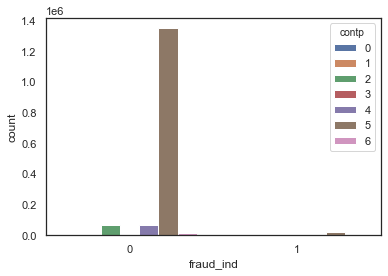

In [17]:
# 5跟4的交易類別人最多
g=sns.countplot(x='fraud_ind',hue='contp',data=dtrain)

In [18]:
# 正常特約商店(mchno)
print(dtrain.mchno.value_counts(normalize=True)[:10])
# 盜刷特約商店(mchno)
print(fraud_1df.mchno.value_counts(normalize=True)[:10])
# mchno
dtrain.loc[dtrain['mchno'].isin([55807,45597,67588,66634,20984,11801,69240]),'mchno_danger']=1

0        0.032772
54828    0.025145
54238    0.024179
59333    0.021217
86584    0.013397
82174    0.012744
78638    0.012659
59369    0.011268
44859    0.010588
544      0.010235
Name: mchno, dtype: float64
54238    0.161582
54828    0.131712
55807    0.107541
45597    0.054188
67588    0.038860
66634    0.036256
20984    0.016212
11801    0.011840
69240    0.010219
79663    0.009383
Name: mchno, dtype: float64


In [19]:
# 正常消費國家(stocn)
print(dtrain.stocn.value_counts(normalize=True)[:10])
# 盜刷消費國家(stocn)
print(fraud_1df.stocn.value_counts(normalize=True)[:10])
# stocn
dtrain.loc[dtrain['stocn'].isin([104,38,46,75,102]),'stocn_danger']=1

102    0.863114
38     0.029118
46     0.027387
104    0.022011
75     0.013227
20     0.011751
52     0.010210
93     0.003431
42     0.002856
44     0.002754
Name: stocn, dtype: float64
104    0.330730
38     0.192631
46     0.149300
75     0.105822
102    0.061164
52     0.025547
6      0.020879
93     0.020192
27     0.016556
20     0.008008
Name: stocn, dtype: float64


In [20]:
#正常的contp
print(dtrain.contp.value_counts())
#盜刷的contp
print(fraud_1df.contp.value_counts())
# contp 
dtrain.loc[dtrain['contp'].isin([0,1,3,6]), 'contp'] = 6

5    1369806
4      69965
2      66147
6      13593
3       2148
1         84
0         44
Name: contp, dtype: int64
5    19553
4      777
3       14
2        8
6        3
Name: contp, dtype: int64


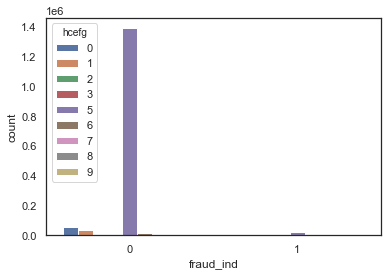

In [21]:
# 支付型態，大多用5
sns.countplot(x='fraud_ind',hue='hcefg',data=dtrain)
# hcefg 
dtrain.loc[dtrain['hcefg'].isin([1,2,3,4]), 'hcefg'] = 4

([<matplotlib.patches.Wedge at 0x2d7b1108>,
 [Text(1.013545136828794, 0.427464917403407, '251'),
  Text(0.5091885742734823, 0.9750523041505715, '247'),
  Text(-0.03696132994233155, 1.0993788519381724, '263'),
  Text(-0.4986112957621424, 0.9805033277548819, '457'),
  Text(-0.8165722802947168, 0.7370276189223078, '292'),
  Text(-0.9926496519705789, 0.47396905852881266, '264'),
  Text(-1.0811076905088841, 0.2029930085558302, '343'),
  Text(-1.0994975163701817, -0.03324472132237754, '451'),
  Text(-1.075508653491801, -0.2308270700421703, '380'),
  Text(-1.020196481300287, -0.41133823010086645, '289')],
 [Text(0.5528428019066148, 0.23316268222004013, '13%'),
  Text(0.2777392223309903, 0.5318467113548572, '9%'),
  Text(-0.020160725423089932, 0.5996611919662759, '7%'),
  Text(-0.27196979768844126, 0.5348199969572083, '7%'),
  Text(-0.4454030619789364, 0.4020150648667133, '5%'),
  Text(-0.5414452647112248, 0.25852857737935236, '4%'),
  Text(-0.5896951039139366, 0.110723459212271, '4%'),
  Text

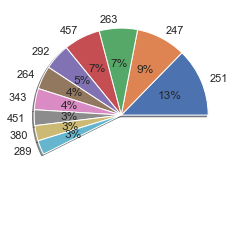

In [22]:
# c=dtrain.mcc.value_counts(normalize = True)
c=dtrain.mcc.value_counts(normalize = True)[:10]
# mcc 不屬於251,247,263,457,292,264,343則歸類於343
dtrain.loc[~dtrain['mcc'].isin([251,247,263,457,292,264,343]), 'mcc'] = 343
# 正常前10大商戶類別(mcc)
plt.pie(c.values,labels=c.index,
autopct='%.0f%%',radius=1,explode=None,shadow=True)

C:\Users\Landy\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Landy\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


([<matplotlib.patches.Wedge at 0x4691e7c8>,
 [Text(0.9172080123232079, 0.6072309792246358, '289'),
  Text(-0.136064137384865, 1.091552358120174, '380'),
  Text(-0.9570531983943015, 0.5422630131617296, '288'),
  Text(-1.0523521123514952, -0.3202421453046841, '192'),
  Text(-0.785194972615412, -0.7703692977913141, '203'),
  Text(-0.6704285642564956, -0.8720811546117564, '337'),
  Text(-0.5544049058153694, -0.9500711554446076, '286'),
  Text(-0.4344229197300907, -1.0105823701278305, '296'),
  Text(-0.3136578365348432, -1.054333325651941, '408'),
  Text(-0.191291604424889, -1.0832393650881378, '277')],
 [Text(0.5002952794490224, 0.33121689775889224, '19%'),
  Text(-0.07421680220992637, 0.5953921953382767, '17%'),
  Text(-0.5220290173059825, 0.2957798253609434, '13%'),
  Text(-0.5740102431008155, -0.17467753380255494, '13%'),
  Text(-0.4282881668811338, -0.4202014351588986, '2%'),
  Text(-0.36568830777627026, -0.4756806297882307, '2%'),
  Text(-0.3024026758992923, -0.5182206302425132, '2%')

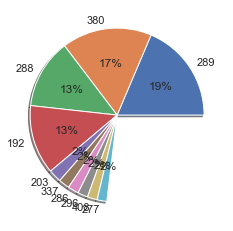

In [23]:
# d=fraud_1df.mcc.value_counts(normalize = True)
d=fraud_1df.mcc.value_counts(normalize = True)[:10]

# mcc 
fraud_1df.loc[fraud_1df['mcc'].isin([289,380,288,192]), 'mcc_danger'] = 1
# 盜刷前10大消費商戶類別(mcc)
plt.pie(d.values,labels=d.index,
autopct='%.0f%%',radius=1,explode=None,shadow=True)

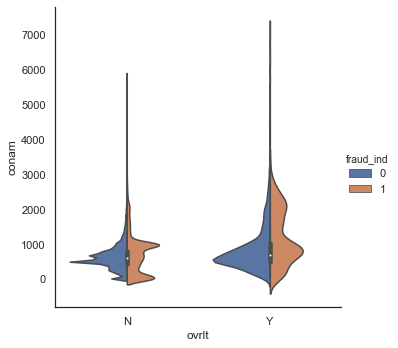

In [24]:
# 卡沒被刷爆：本來就沒什麼額度 or 1000左右，卡刷爆了：800左右 or 2000左右
sns.catplot(x='ovrlt',y='conam',hue='fraud_ind',kind="violin", split=True,data=dtrain)


In [25]:
# 卡沒被刷爆的盜刷：小額盜刷 or 800~1000左右
dtrain['ovrltN_conam0_200_or_800_1200']=0
dtrain.loc[(dtrain.conam<200) & (800<dtrain.conam) & (dtrain.conam<1200), 'ovrltN_conam0_200_or_800_1200'] = 1
dtrain.loc[dtrain.ovrlt==str("Y"), 'ovrltN_conam0_200_or_800_1200'] = 0
# 卡刷爆了：1200~3000左右
dtrain['ovrltY_conam1200_3000']=0
dtrain.loc[(1200<dtrain.conam) & (dtrain.conam<3000), 'ovrltY_conam1200_3000'] = 1
dtrain.loc[dtrain.ovrlt==str("N"), 'ovrltY_conam1200_3000'] = 0

In [26]:
dtrain.describe()

,acqic,bacno,cano,conam,contp,csmcu,etymd,fraud_ind,hcefg,iterm,locdt,mcc,mchno,scity,stocn,stscd,txkey,Month,Count_txkey_gb_same_person,Count_txkey_gb_same_card,Count_txkey_gb_same_card_same_day,Count_txkey_gb_same_card_same_hour,Count_txkey_gb_same_card_same_day_ecfg,Percent_of_ecfg,ecfgY_conam1000_1500,ecfgN_conam0_400,mchno_danger,stocn_danger,ovrltN_conam0_200_or_800_1200,ovrltY_conam1200_3000
count,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,1.521787e+06,14701.0,1453087.0,1521787.0,1.521787e+06
mean,6.008003e+03,8.209027e+04,1.089170e+05,6.547219e+02,4.834052e+00,5.383324e+01,4.149114e+00,1.337572e-02,4.819201e+00,4.962784e-02,4.532732e+01,3.185569e+02,5.589022e+04,4.755128e+03,9.565116e+01,2.485499e-02,9.711265e+05,1.994694e+00,4.362131e+01,3.327648e+01,2.129102e+00,6.014461e+00,1.985528e+00,1.513199e-01,2.862359e-02,1.368759e-01,1.0,1.0,0.0,2.422152e-03
std,1.502420e+03,4.736249e+04,6.090363e+04,4.028078e+02,6.481242e-01,2.072135e+01,2.394259e+00,1.148774e-01,9.603985e-01,3.652493e-01,2.601889e+01,5.537727e+01,3.082297e+04,1.979815e+03,1.890027e+01,2.216804e-01,5.641322e+05,8.195087e-01,6.075484e+01,5.483266e+01,4.339109e+00,3.745392e+01,4.076539e+00,2.936064e-01,1.667462e-01,3.437164e-01,0.0,0.0,0.0,4.915574e-02
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.470000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,0.0,0.000000e+00
25%,5.982000e+03,4.140300e+04,5.763500e+04,4.370600e+02,5.000000e+00,6.200000e+01,2.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,2.300000e+01,2.630000e+02,3.377400e+04,3.795000e+03,1.020000e+02,0.000000e+00,4.869475e+05,1.000000e+00,1.500000e+01,1.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,0.0,0.000000e+00
50%,6.716000e+03,8.191200e+04,1.097850e+05,5.919000e+02,5.000000e+00,6.200000e+01,4.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,4.500000e+01,3.430000e+02,5.936000e+04,5.817000e+03,1.020000e+02,0.000000e+00,9.795800e+05,2.000000e+00,2.900000e+01,2.200000e+01,1.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,0.0,0.000000e+00
75%,6.769000e+03,1.230590e+05,1.618760e+05,8.073400e+02,5.000000e+00,6.200000e+01,5.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,6.800000e+01,3.430000e+02,7.920000e+04,5.817000e+03,1.020000e+02,0.000000e+00,1.455200e+06,3.000000e+00,5.200000e+01,4.000000e+01,2.000000e+00,5.000000e+00,2.000000e+00,8.163265e-02,0.000000e+00,0.000000e+00,1.0,1.0,0.0,0.000000e+00
max,6.884000e+03,1.638840e+05,2.133340e+05,7.208770e+03,6.000000e+00,7.500000e+01,1.000000e+01,1.000000e+00,9.000000e+00,8.000000e+00,9.000000e+01,4.570000e+02,1.033070e+05,6.671000e+03,1.070000e+02,4.000000e+00,1.958239e+06,3.000000e+00,1.117000e+03,1.117000e+03,1.790000e+02,1.060000e+03,1.790000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0,0.0,1.000000e+00


In [27]:
num3=dtrain[(dtrain['ovrlt'] == str('Y')) & (dtrain['fraud_ind']==1)].count()['txkey'] / dtrain[ dtrain['ovrlt'] == str('Y')].count()['txkey']
print("ovrlt=Y時盜刷比率"+"%0.2f" % num3)

ovrlt=Y時盜刷比率0.03


In [28]:
num4=dtrain[(dtrain['ecfg'] == str('Y')) & (dtrain['fraud_ind']==1)].count()['txkey'] / dtrain[ dtrain['ecfg'] == str('Y')].count()['txkey']
print("ecfg=Y時盜刷比率"+"%0.2f" % num4)

ecfg=Y時盜刷比率0.05


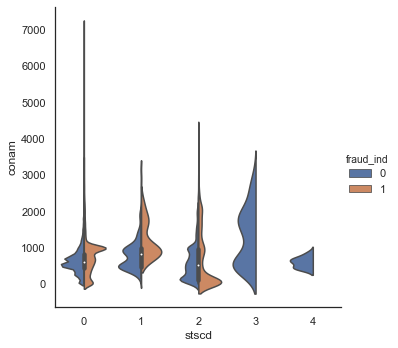

In [29]:
# 狀態碼，3 & 4都沒被盜刷
sns.catplot(x='stscd',y='conam',hue='fraud_ind',kind="violin", split=True,data=dtrain)
# 將狀態碼(stscd) 3.4合併
dtrain.loc[dtrain['stscd'].isin([3,4]),'stscd']=3

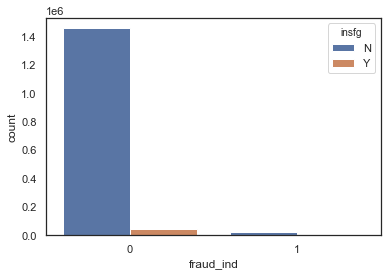

In [30]:
# 分期交易註記，盜刷幾乎不分期
sns.countplot(x='fraud_ind',hue='insfg',data=dtrain)

In [31]:
print(dtrain.etymd.value_counts(normalize=True)[:10])
print(fraud_1df.etymd.value_counts(normalize=True)[:10])
# etymd
dtrain.loc[dtrain['etymd']==8,'etymd_danger']=1

5    0.265879
2    0.248175
4    0.210609
8    0.160335
0    0.085440
9    0.019764
1    0.006794
3    0.001544
6    0.001300
7    0.000150
Name: etymd, dtype: float64
8    0.568312
2    0.383395
5    0.009973
0    0.008990
4    0.008597
9    0.008352
6    0.007124
7    0.003292
1    0.001130
3    0.000835
Name: etymd, dtype: float64


In [32]:
# 去過的城市數量
r=dtrain.groupby('bacno')['scity'].transform('count')
dtrain=dtrain.sort_values(by=['cano'],ascending=True)
dtrain = pd.concat((dtrain, r.rename('cano_scity_count')), axis=1)
# print(r.agg(np.size))

In [33]:
print(dtrain.acqic.value_counts(normalize=True)[:10])
print(fraud_1df.acqic.value_counts(normalize=True)[:10])
# acqic
dtrain.loc[dtrain.acqic.isin([3348,3321,6215,6540,5720,6760,3207]),'acqic_danger']=1

6769    0.164865
6716    0.132349
5975    0.082108
6881    0.065284
6189    0.060083
6767    0.053376
6032    0.040900
6231    0.036104
0       0.031502
3348    0.029526
Name: acqic, dtype: float64
3348    0.198035
3221    0.120609
6215    0.102186
6540    0.081995
5720    0.058659
6760    0.046328
3207    0.033702
6331    0.016556
6769    0.012822
3288    0.012085
Name: acqic, dtype: float64


In [34]:
dtrain.isna().sum()

acqic                                           0
bacno                                           0
cano                                            0
conam                                           0
contp                                           0
csmcu                                           0
ecfg                                            0
etymd                                           0
flbmk                                           0
flg_3dsmk                                       0
fraud_ind                                       0
hcefg                                           0
insfg                                           0
iterm                                           0
locdt                                           0
loctm                                           0
mcc                                             0
mchno                                           0
ovrlt                                           0
scity                                           0


In [35]:
# fillna
dtrain.fillna(value=0,inplace=True)
# handle Y,N,NA
dtrain.replace('Y',1,inplace=True)
dtrain.replace('N',0,inplace=True)
dtrain.replace('NA',2,inplace=True)

In [36]:
# from sklearn.preprocessing import MinMaxScaler
# scaler=MinMaxScaler()
# dtrain[dtrain.columns]=scaler.fit_transform(dtrain[dtrain.columns])
# dtrain

In [37]:
# Numerical：conam,Count_txkey_gb_same_person...
# Must be numerical：acqic,cano_scity,count
# Categorical：(contp),csmcu,ecfg,(hcefg),ovrlt,(stscd),(mcc),month,loctm_hour,flbmk
# Not in；bacno,cano,locdt,loctm,txkey,iterm,insfg,flg_3dsmk,scity,mchno
# Danger：acqic,mcc,stocn,etymd,scity(count),mchno(0or1)
col_names=[c for c in dtrain.columns if c not in ['fraud_ind','bacno','cano','locdt','loctm', 'txkey', 'loctm','iterm','insfg','flg_3dsmk','scity','mchno']]
categorical_features = [c for c in dtrain.columns if c not in ['fraud_ind','conam','Count_txkey_gb_same_person','Count_txkey_gb_same_card','Count_txkey_gb_same_card_same_day','Count_txkey_gb_same_card_same_hour','Count_txkey_gb_same_card_same_day_ecfg','Percent_of_ecfg','bacno','cano','locdt','loctm', 'txkey', 'iterm','insfg','flg_3dsmk','scity','mchno','acqic','cano_scity_count']]
dtrain[categorical_features]

,contp,csmcu,ecfg,etymd,flbmk,hcefg,mcc,ovrlt,stocn,stscd,Month,loctm_hour,ecfgY_conam1000_1500,ecfgN_conam0_400,mchno_danger,stocn_danger,ovrltN_conam0_200_or_800_1200,ovrltY_conam1200_3000,etymd_danger,acqic_danger
0,5,0,0,0,0,5,457,0,102,0,2,17,0,0,0.0,1.0,0,0,0.0,0.0
1,5,0,0,2,0,0,343,0,102,0,1,10,0,0,0.0,1.0,0,0,0.0,0.0
2,5,0,0,0,0,5,457,0,102,0,1,15,0,0,0.0,1.0,0,0,0.0,0.0
3,5,62,0,5,0,5,247,0,102,0,1,17,0,0,0.0,1.0,0,0,0.0,0.0
4,5,62,0,4,0,5,263,0,102,0,1,18,0,0,0.0,1.0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521782,5,75,1,8,2,6,343,0,102,0,1,19,0,0,0.0,1.0,0,0,1.0,0.0
1521783,5,75,1,8,2,6,343,0,102,0,1,10,0,0,0.0,1.0,0,0,1.0,0.0
1521784,5,75,1,8,2,6,343,0,102,0,1,23,0,0,0.0,1.0,0,0,1.0,0.0
1521785,5,75,1,2,2,6,343,0,102,0,1,21,0,0,0.0,1.0,0,0,0.0,0.0


In [38]:
dtrain.nunique()

acqic                                        6051
bacno                                       95214
cano                                       129413
conam                                       72961
contp                                           4
csmcu                                          72
ecfg                                            2
etymd                                          11
flbmk                                           3
flg_3dsmk                                       3
fraud_ind                                       2
hcefg                                           7
insfg                                           2
iterm                                           9
locdt                                          90
loctm                                       84810
mcc                                             7
mchno                                       89316
ovrlt                                           2
scity                                        5698


In [39]:
dtrain[categorical_features].nunique()

contp                              4
csmcu                             72
ecfg                               2
etymd                             11
flbmk                              3
hcefg                              7
mcc                                7
ovrlt                              2
stocn                            103
stscd                              4
Month                              3
loctm_hour                        24
ecfgY_conam1000_1500               2
ecfgN_conam0_400                   2
mchno_danger                       2
stocn_danger                       2
ovrltN_conam0_200_or_800_1200      1
ovrltY_conam1200_3000              2
etymd_danger                       2
acqic_danger                       2
dtype: int64

In [40]:
from sklearn.model_selection import train_test_split

dtrain[dtrain.columns]=dtrain[dtrain.columns].astype(int)
#fraud_ind=y
X_train, X_valid, y_train, y_valid = train_test_split(dtrain[col_names], dtrain['fraud_ind'], test_size=0.3, random_state=666)
X_train

,acqic,conam,contp,csmcu,ecfg,etymd,flbmk,hcefg,mcc,ovrlt,stocn,stscd,Month,loctm_hour,Count_txkey_gb_same_person,Count_txkey_gb_same_card,Count_txkey_gb_same_card_same_day,Count_txkey_gb_same_card_same_hour,Count_txkey_gb_same_card_same_day_ecfg,Percent_of_ecfg,ecfgY_conam1000_1500,ecfgN_conam0_400,mchno_danger,stocn_danger,ovrltN_conam0_200_or_800_1200,ovrltY_conam1200_3000,etymd_danger,cano_scity_count,acqic_danger
577742,6881,513,5,0,0,0,0,5,457,0,102,0,1,18,9,9,1,1,1,0,0,0,0,1,0,0,0,9,0
1107144,5975,793,5,62,0,4,0,5,263,0,102,0,2,19,54,32,3,5,3,0,0,0,0,1,0,0,0,54,0
1271300,5666,942,5,62,1,8,0,5,343,0,102,0,3,1,44,23,1,1,1,0,0,0,0,1,0,0,1,44,0
1317941,3217,567,5,13,1,8,0,5,247,0,20,0,1,0,8,7,1,2,1,1,0,0,0,0,0,0,1,8,0
62836,5975,768,5,62,0,4,0,5,263,0,102,0,1,10,40,27,1,3,1,0,0,0,0,1,0,0,0,40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370057,6540,0,5,61,0,2,0,5,343,0,104,0,3,22,25,25,2,5,1,0,0,1,0,1,0,0,0,25,1
303174,6231,622,5,62,1,2,0,5,343,0,102,0,1,21,20,20,2,2,1,0,0,0,0,1,0,0,0,20,0
1051454,6767,735,5,62,0,4,0,5,292,0,102,0,1,14,51,30,2,3,2,0,0,0,0,1,0,0,0,51,0
337794,5975,708,5,62,0,5,0,5,343,0,102,0,3,17,12,1,1,1,1,0,0,0,0,1,0,0,0,12,0


In [66]:
# catboost可自行設定 learning rate
model = CatBoostClassifier(
                         iterations=500,
                          class_weights=[1.0,2.5],
                           cat_features=categorical_features,
                           one_hot_max_size=103,
                           loss_function='Logloss',
                           eval_metric='F1',
                           logging_level='Verbose',
                           use_best_model=True)

# CatBoost with GridSearch
# start = time.time()
# param_grid=[{'n_estimators':[10,100],
#             'learning_rate':[0.05,0.1],
#             'rsm':[0.5,0.8]}]
# cat_gs = GridSearch(CatBoostClassifier(random_state=42, silent = True,
                        # bootstrap_type = 'Bernoulli'), param_grid, X_train[:4000], y_train[:4000], X_test, y_test)

In [67]:

model.fit(X_train,y_train,
          eval_set=(X_valid, y_valid),
          cat_features=categorical_features,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.239683
0:	learn: 0.5859564	test: 0.5813001	best: 0.5813001 (0)	total: 341ms	remaining: 2m 50s
1:	learn: 0.5270048	test: 0.5271273	best: 0.5813001 (0)	total: 640ms	remaining: 2m 39s
2:	learn: 0.5425134	test: 0.5414185	best: 0.5813001 (0)	total: 972ms	remaining: 2m 41s
3:	learn: 0.5415737	test: 0.5380317	best: 0.5813001 (0)	total: 1.26s	remaining: 2m 36s
4:	learn: 0.5547275	test: 0.5483206	best: 0.5813001 (0)	total: 1.97s	remaining: 3m 14s
5:	learn: 0.5832685	test: 0.5799446	best: 0.5813001 (0)	total: 3.04s	remaining: 4m 10s
6:	learn: 0.5861016	test: 0.5826612	best: 0.5826612 (6)	total: 3.4s	remaining: 3m 59s
7:	learn: 0.6058610	test: 0.6048917	best: 0.6048917 (7)	total: 3.74s	remaining: 3m 50s
8:	learn: 0.6133809	test: 0.6095907	best: 0.6095907 (8)	total: 4.06s	remaining: 3m 41s
9:	learn: 0.6222930	test: 0.6184070	best: 0.6184070 (9)	total: 4.39s	remaining: 3m 34s
10:	learn: 0.6297648	test: 0.6240217	best: 0.6240217 (10)	total: 4.72s	remaining: 3m 29s
11:	learn: 0

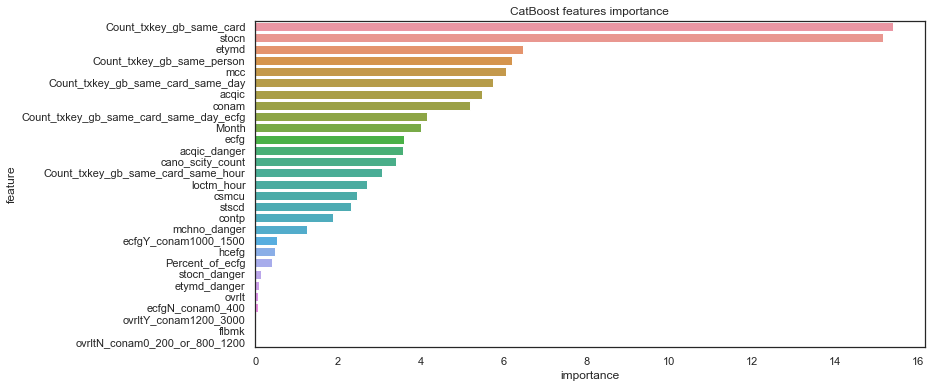

In [68]:
def feature_importances(df, model):
    max_num_features=100
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title('CatBoost features importance');
#     plt.savefig("C:/Users/Landy/Desktop/Angela/esun_credit/catboost_importance.png")
    
feature_importances(X_train, model)

In [60]:
# SMOTE：Synthetic Minority Over-sampling Technique (合成少數類過採樣技術）
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Resample the minority class. You can change the strategy to ‘auto’ if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=777)

# Fit the model to generate the data.

oversampled_trainX,oversampled_trainY = sm.fit_sample(X_train,y_train)

print(Counter(oversampled_trainY))

Counter({0: 1050843, 1: 1050843})


In [61]:
ovs_trainX, ovs_validX, ovs_trainY, ovs_validY = train_test_split( 
    oversampled_trainX, oversampled_trainY, 
    test_size=0.3, random_state=666)

In [69]:
model2 = CatBoostClassifier(
                         iterations=500,
#                           class_weights=[1.0,2.5],
                           cat_features=categorical_features,
                           one_hot_max_size=103,
                           loss_function='Logloss',
                           eval_metric='F1',
                           logging_level='Verbose',
                           use_best_model=True)

In [70]:

model2.fit(ovs_trainX, ovs_trainY,
          eval_set=(ovs_validX, ovs_validY),
          cat_features=categorical_features,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.25958
0:	learn: 0.9269063	test: 0.9269231	best: 0.9269231 (0)	total: 1.36s	remaining: 11m 19s
1:	learn: 0.9310522	test: 0.9314627	best: 0.9314627 (1)	total: 2.34s	remaining: 9m 42s
2:	learn: 0.9327348	test: 0.9328744	best: 0.9328744 (2)	total: 3.25s	remaining: 8m 58s
3:	learn: 0.9346097	test: 0.9349597	best: 0.9349597 (3)	total: 4.19s	remaining: 8m 39s
4:	learn: 0.9350599	test: 0.9354277	best: 0.9354277 (4)	total: 5.13s	remaining: 8m 28s
5:	learn: 0.9362397	test: 0.9366482	best: 0.9366482 (5)	total: 6.4s	remaining: 8m 47s
6:	learn: 0.9368874	test: 0.9372035	best: 0.9372035 (6)	total: 7.51s	remaining: 8m 48s
7:	learn: 0.9378808	test: 0.9381607	best: 0.9381607 (7)	total: 8.51s	remaining: 8m 43s
8:	learn: 0.9392034	test: 0.9395998	best: 0.9395998 (8)	total: 9.63s	remaining: 8m 45s
9:	learn: 0.9402725	test: 0.9405596	best: 0.9405596 (9)	total: 10.7s	remaining: 8m 43s
10:	learn: 0.9409473	test: 0.9411891	best: 0.9411891 (10)	total: 11.8s	remaining: 8m 42s
11:	learn: 0

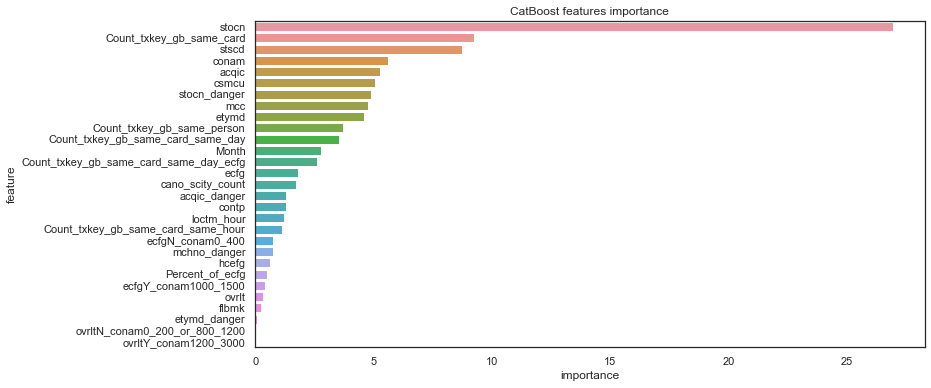

In [65]:
def feature_importances(df, model):
    max_num_features=100
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title('CatBoost features importance');
#     plt.savefig("C:/Users/Landy/Desktop/Angela/esun_credit/catboost_importance.png")
    
feature_importances(ovs_trainX, model2)